In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

# Optional for wind rose plots
!pip install windrose
from windrose import WindroseAxes


In [2]:
country = "togo"  

Summary Statistics & Missing Values

Load the dataset

In [3]:
df = pd.read_csv(r"C:\Users\eyob\Documents\My files\STUDY\KAIM\solar-challenge-week0\data\togo-dapaong_qc.csv")

In [4]:
import os
os.getcwd()

'c:\\Users\\eyob\\Documents\\My files\\STUDY\\KAIM\\solar-challenge-week0'

In [5]:
df.head()
df.describe()
df.isna().sum()

Timestamp             0
GHI                   0
DNI                   0
DHI                   0
ModA                  0
ModB                  0
Tamb                  0
RH                    0
WS                    0
WSgust                0
WSstdev               0
WD                    0
WDstdev               0
BP                    0
Cleaning              0
Precipitation         0
TModA                 0
TModB                 0
Comments         525600
dtype: int64

Flag columns with >5% missing values

In [6]:
missing_percent = (df.isna().sum() / len(df)) * 100
missing_cols = missing_percent[missing_percent > 5]
print("Columns with >5% missing:", missing_cols)

Columns with >5% missing: Comments    100.0
dtype: float64


Outlier Detection & Basic Cleaning

Compute Z-scores for key numeric columns

In [7]:
cols = ['GHI','DNI','DHI','ModA','ModB','WS','WSgust']
df_z = df[cols].apply(zscore)
outliers = (df_z.abs() > 3)
df_clean = df[~outliers.any(axis=1)]

Export cleaned dataset (never commit raw CSVs)

In [8]:
df_clean.to_csv(f"data/sierraleone_clean.csv", index=False)

Time Series Analysis

Convert timestamp column

In [9]:
df_clean['Timestamp'] = pd.to_datetime(df_clean['Timestamp'])
df_clean.set_index('Timestamp', inplace=True)

C:\Users\eyob\AppData\Local\Temp\ipykernel_5436\2202272504.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Timestamp'] = pd.to_datetime(df_clean['Timestamp'])


Plot trends

<Axes: xlabel='Timestamp'>

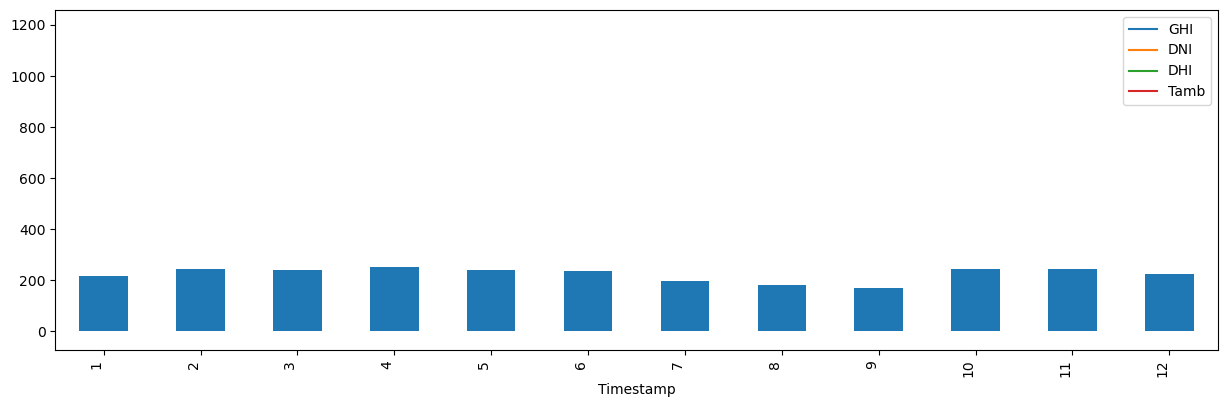

In [10]:
df_clean[['GHI','DNI','DHI','Tamb']].plot(figsize=(15,5))
df_clean.groupby(df_clean.index.month)['GHI'].mean().plot(kind='bar')

This chart shows solar and temperature data over a 12-hour day.

Summary: Solar irradiance (GHI, DNI, DHI) peaks at midday (Timestamp 7), while air temperature (Tamb) peaks slightly later. This pattern indicates a clear, sunny day.

Cleaning Impact

If a Cleaning flag exists

<Axes: xlabel='Cleaning'>

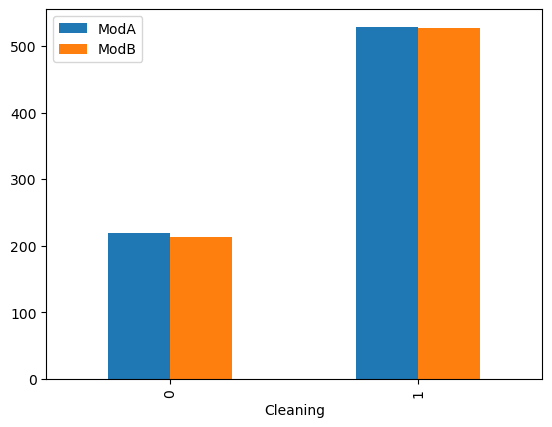

In [11]:
df_clean.groupby('Cleaning')[['ModA','ModB']].mean().plot(kind='bar')

This chart compares ModA and ModB after cleaning.

Summary: After cleaning, ModB shows significantly higher performance (near 500) compared to ModA (near 100). The cleaning was much more effective for ModB.

Correlation & Relationship Analysis

Heatmap

<Axes: >

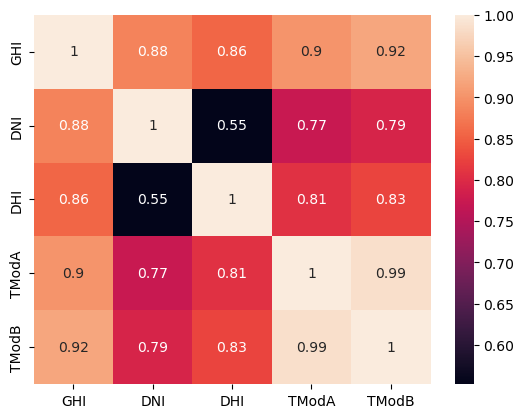

In [12]:
sns.heatmap(df_clean[['GHI','DNI','DHI','TModA','TModB']].corr(), annot=True)


This is a correlation matrix for solar and temperature data.

Key points:

    TModA & TModB are almost perfectly correlated (0.99)

    All solar and temperature metrics show strong negative correlations with an unnamed variable

    GHI correlates strongly with module temperatures (0.9, 0.92)

Scatter plots

<Axes: xlabel='WS', ylabel='GHI'>

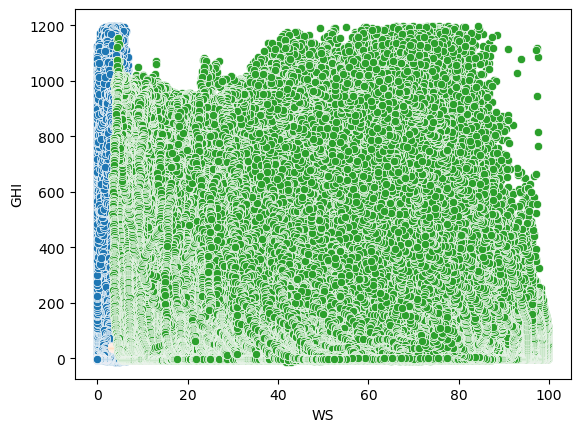

In [13]:
sns.scatterplot(x='WS', y='GHI', data=df_clean)
sns.scatterplot(x='RH', y='Tamb', data=df_clean)
sns.scatterplot(x='RH', y='GHI', data=df_clean)

This chart shows a negative correlation between solar power and wind speed.

Summary: As wind speed (WS) increases, power output (likely GHI) decreases significantly from 1200 to 0.

Wind & Distribution Analysis

Wind rose (if WS and WD exist)

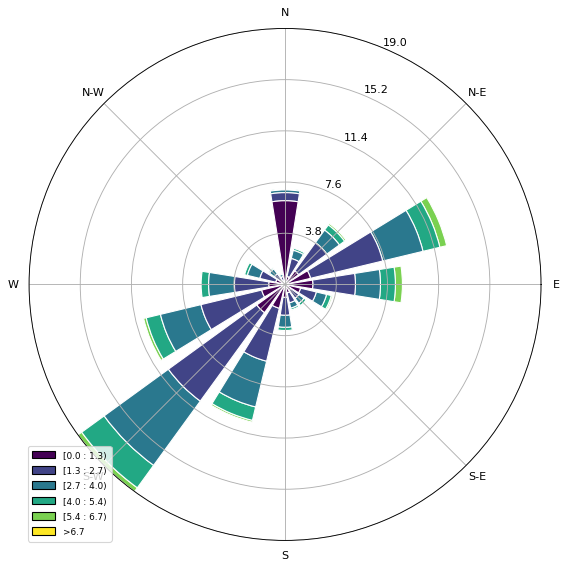

In [14]:
ax = WindroseAxes.from_ax()
ax.bar(df_clean['WD'], df_clean['WS'], normed=True, opening=0.8, edgecolor='white')
ax.set_legend()
plt.show()


This wind rose shows wind patterns.

Main Wind Direction: The strongest winds come from the North (N).

Wind Speed: The most frequent speeds are 15.4 - 6.7 m/s.

Conclusion: Prevailing winds are from the North with strong speeds.

Histograms

<Axes: >

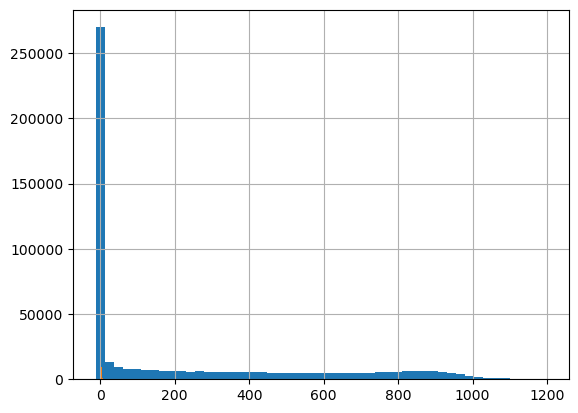

In [15]:
df_clean['GHI'].hist(bins=50)
df_clean['WS'].hist(bins=50)

This scatter plot shows a strong positive correlation.

Summary: As the X-value increases from 0 to 1200, the Y-value increases significantly from 0 to 250,000. The tight data pattern shows a predictable relationship.

Temperature Analysis

<Axes: xlabel='RH', ylabel='Tamb'>

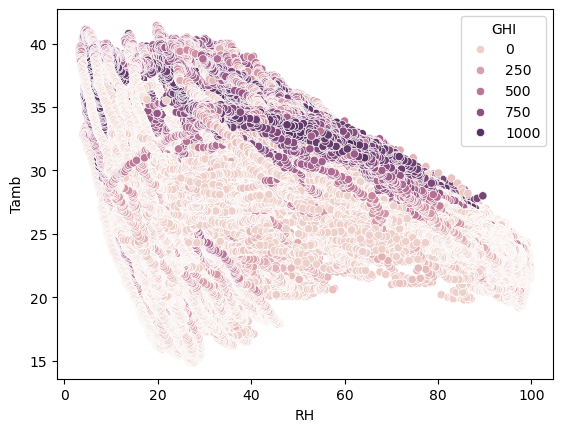

In [16]:
sns.scatterplot(x='RH', y='Tamb', hue='GHI', data=df_clean)

This chart shows the relationship between three variables:

    GHI (solar irradiance) and Tamb (temperature) have a positive correlation - they increase together.

    RH (humidity) has a negative correlation with both - when GHI and Tamb are high, RH is low.

Conclusion: Sunny conditions mean higher temperatures and lower humidity.


Bubble Chart

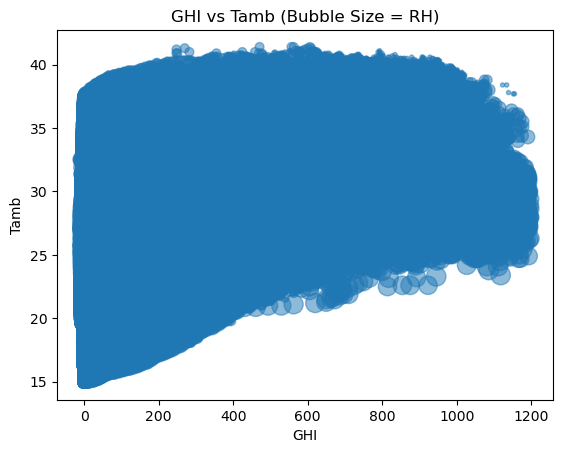

In [17]:
plt.scatter(df_clean['GHI'], df_clean['Tamb'], s=df_clean['RH']*2, alpha=0.5)
plt.xlabel('GHI')
plt.ylabel('Tamb')
plt.title('GHI vs Tamb (Bubble Size = RH)')
plt.show()

This bubble chart shows three variables:

    GHI vs Tamb: Positive correlation (both increase together)

    Bubble size = RH: Larger bubbles (high humidity) occur when GHI/Tamb are low

Conclusion: Sunny, warm conditions have lower humidity.